In [1]:
import sys
import os
import gc
# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
from MnistHelperFunctions.get_standard_data import class_wise_preprocessed_mnist, preprocessed_mnist
train_datas, test_datas, test_data_for_repository = class_wise_preprocessed_mnist()

inside getting data


Data format: 
--------------------------------
type(train_datas[i].data[0]) -> <class 'torch.Tensor'>
train_datas[i].data[0].dtype -> torch.float32

type(train_datas[i].targets) -> <class 'torch.Tensor'>
train_datas[i].targets.dtype -> torch.int64


Access Data by indexing
--------------------------------
train_datas[i][0] -> (torch.Size([28, 28]), torch.Size([]))


max and min values of train_datas[i].data:
--------------------------------
	[(tensor(0.), tensor(1.))]





In [3]:
torch.manual_seed(42)

repository_size = 10
NUM_DIMENSIONS = 28*28
NUM_EPOCHS = 100
label_for_zero = 0
BATCH_SIZE = 256
learning_rate = 0.01


n_train_zeros = 600_000
n_test_zeros = 100_000

device="cuda" if torch.cuda.is_available() else "cpu"



In [4]:
from ZeroHelperFunctions.DataLoadersForZero import DataLoadersForZero
from Networks.networks import FullyConnectedNet
from ZeroHelperFunctions.zeroTrainer import ZeroTrainer

from torch import nn

from ZeroHelperFunctions import plots
from ZeroHelperFunctions.Curiosity import CuriosityRover

mnist_rover = CuriosityRover(device="cuda" if torch.cuda.is_available() else "cpu")

for cl in range(repository_size):
    print(f"Class-{cl} training ...")
    dl = DataLoadersForZero(train_data=train_datas[cl],
                            test_data=test_datas[cl],
                            image_shape=(1, 28, 28))
    dl.make_dataloaders(batch_size=BATCH_SIZE,
                        n_train_zeros=n_train_zeros,
                        n_test_zeros=n_test_zeros,
                        label_for_zero=label_for_zero)
    # dl.show_border_images_of_combined_data(6000)
    dl.generate_zero_class_dataloader(10000, BATCH_SIZE)
    # dl.check_dataloader(dl.zero_dataloader)
    # dl.check_dataloader(dl.train0_dataloader)
    # dl.check_dataloader(dl.train_dataloader)
    # dl.check_dataloader(dl.test_dataloader)
    # dl.check_dataloader(dl.test0_dataloader)
    
    # dl.check_elements_of_train_data_if_tensors()
    # dl.check_elements_of_zero_class_if_tensors()
    
    # dl.describe_train_data()
    # dl.describe_zero_class_data()
    zero_model = FullyConnectedNet(input_dim=NUM_DIMENSIONS,
                                   layer1_dim=NUM_DIMENSIONS*2,
                                   layer2_dim=NUM_DIMENSIONS*2,
                                   layer3_dim=50,
                                   num_classes=2)
    zero_trainer = ZeroTrainer(model=zero_model,
                               number_of_non_zero_classes=1,
                               train_dl=dl.train0_dataloader,
                               test_dl=dl.test_dataloader,
                               purity_fact_dl=dl.test0_dataloader,
                               zero_dl=dl.zero_dataloader,
                               loss_fn=nn.CrossEntropyLoss(),
                               optimizer=torch.optim.SGD(params=zero_model.parameters(), lr=learning_rate),
                               label_of_zero_class=label_for_zero,
                               device=device)
    zero_trainer.train(epochs=NUM_EPOCHS)
    plots.plot_pf(zero_trainer.purities, title=f"class-{cl}", path="plots/singles/purity")
    plots.plot_of(zero_trainer.occupancy, title=f"class-{cl}", path="plots/singles/occupancy")
    plots.plot_train_test_losses(zero_trainer.train_loss,
                                 zero_trainer.test_loss, title=f"class-{cl}", path="plots/singles/losses")
    plots.plot_train_test_accs(zero_trainer.train_acc,
                               zero_trainer.test_acc, title=f"class-{cl}", path="plots/singles/accs")
    mnist_rover.add_model_for_an_anomaly(zero_model, f"MNIST - {cl}")

Class-0 training ...
Training...(epochs: 2)
Epoch: 0
----------------
Epoch: 1
----------------
Plot saved to plots/singles/purity/class-0/class-0_purity_factors.pdf
Plot saved to plots/singles/occupancy/class-0/class-0_occupancy_factor.pdf
Plot saved to plots/singles/losses/class-0/class-0_losses.pdf
Plot saved to plots/singles/accs/class-0/accuracies.pdf
Class-1 training ...
Training...(epochs: 2)
Epoch: 0
----------------
Epoch: 1
----------------
Plot saved to plots/singles/purity/class-1/class-1_purity_factors.pdf
Plot saved to plots/singles/occupancy/class-1/class-1_occupancy_factor.pdf
Plot saved to plots/singles/losses/class-1/class-1_losses.pdf
Plot saved to plots/singles/accs/class-1/accuracies.pdf
Class-2 training ...
Training...(epochs: 2)
Epoch: 0
----------------
Epoch: 1
----------------
Plot saved to plots/singles/purity/class-2/class-2_purity_factors.pdf
Plot saved to plots/singles/occupancy/class-2/class-2_occupancy_factor.pdf
Plot saved to plots/singles/losses/class-

## we want combined test set.


In [5]:
from torch.utils.data import DataLoader

test_dataloader_for_repository = DataLoader(test_data_for_repository,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

In [6]:
from ZeroHelperFunctions.Mismatches import Mismatches
mismatch = Mismatches(test_dataloader_for_repository, mnist_rover)

In [7]:
mismatch.test_acc

18.544921875

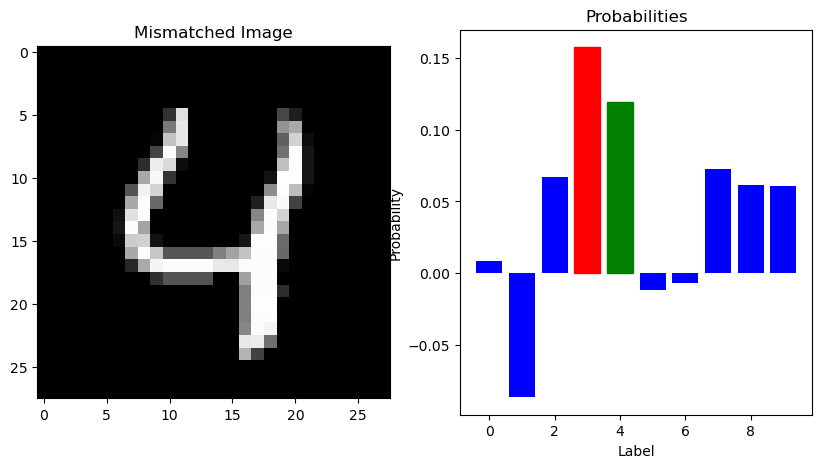

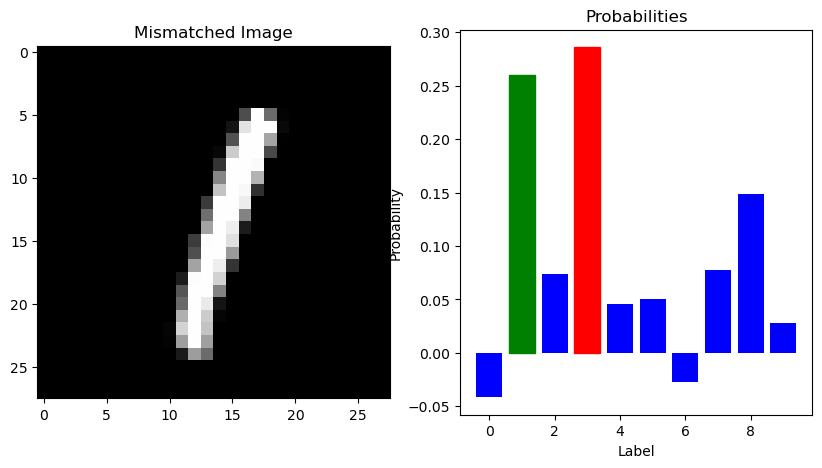

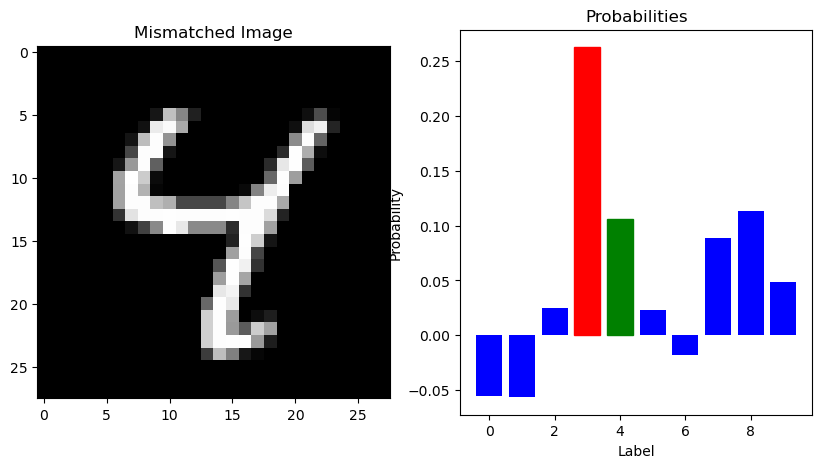

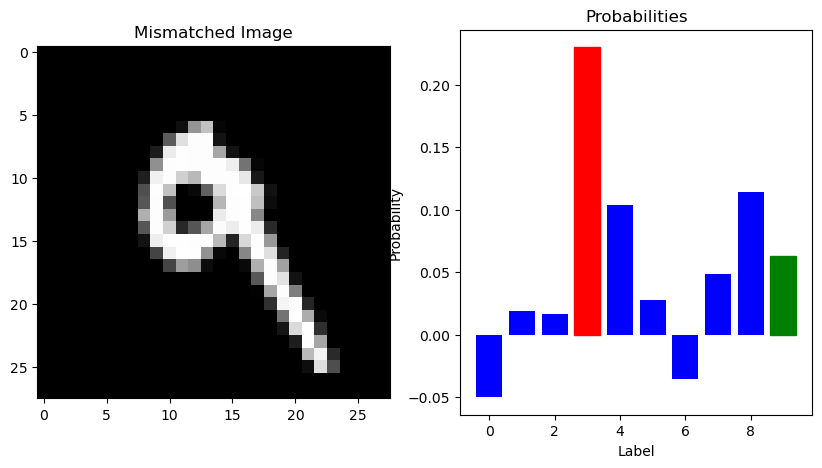

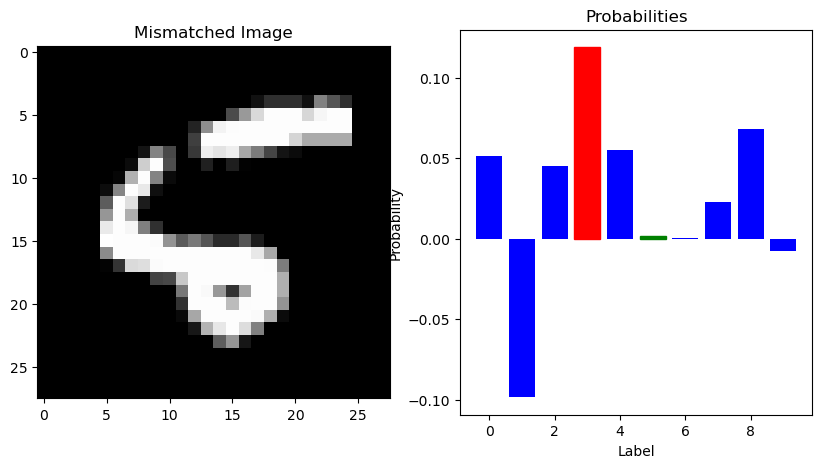

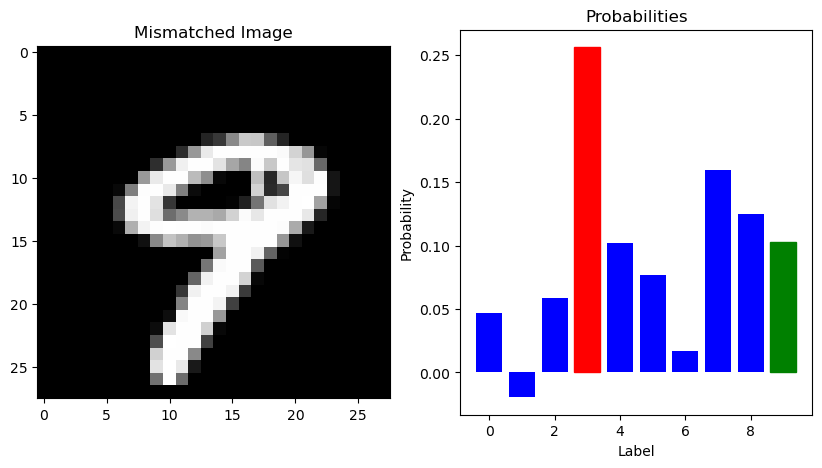

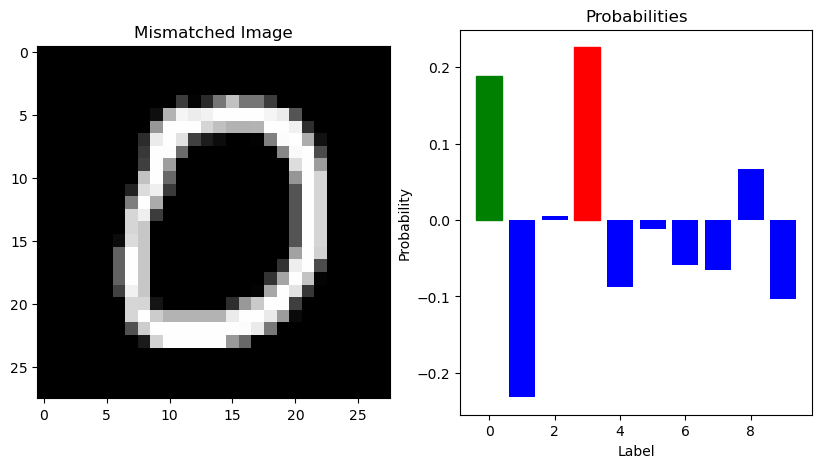

In [8]:
mismatch.plot_mismatches(3, 10)

In [9]:
from ZeroHelperFunctions.zero_class_images_generator_mnist import ZeroClassDataset

In [10]:
zero_vector_data = ZeroClassDataset(num_samples=10, image_shape=(1, 28, 28), label=label_for_zero)

In [11]:
zero_vector_data.data[0].shape


torch.Size([28, 28])

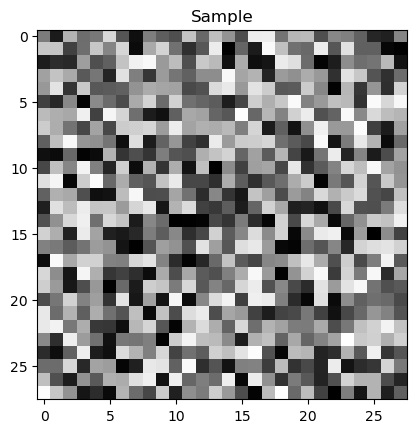

In [12]:
from ZeroHelperFunctions.show_image import show_one_grayscale_image
show_one_grayscale_image(zero_vector_data.data[0])

In [13]:
xk = zero_vector_data.data[0]

def generate(starting_noise, class_name, step_size, iterations=100, print_freq=10):
    xk = starting_noise
    xk = xk.clone().detach().requires_grad_(True) 
    xk.shape, xk.requires_grad
    zero_model = mnist_rover.learned_anomaly_models[class_name]
    zero_model.eval()
    logits = zero_model(xk.to("cuda" if torch.cuda.is_available() else "cpu"))
    target_logit = logits[:, 1]
    target_logit
    target_logit.backward()
    gradients = xk.grad
    xk = xk + gradients * step_size
    xk[0].shape
    print("wtf")
    show_one_grayscale_image(xk[0].detach().cpu().numpy(), title=f"Class-{class_name}")
    for i in range(iterations):
        xk = xk.clone().detach().requires_grad_(True) 
        xk.shape, xk.requires_grad
        zero_model.eval()
        logits = zero_model(xk.to("cuda" if torch.cuda.is_available() else "cpu"))
        target_logit = logits[:, 1]
        target_logit
        target_logit.backward()
        gradients = xk.grad
        xk = xk + gradients * step_size
        xk[0].shape
        if i % print_freq == 0:
            print("iteration number: ", i)
            show_one_grayscale_image(xk[0].detach().cpu().numpy(), title=f"Class-{class_name}")
    return xk

wtf


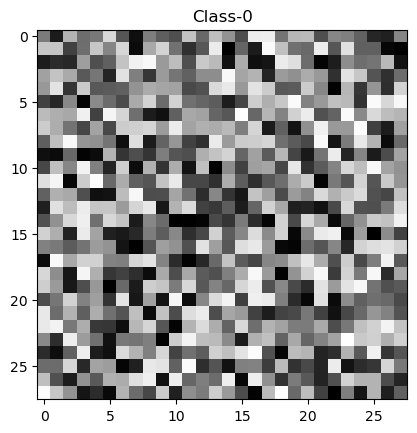

iteration number:  0


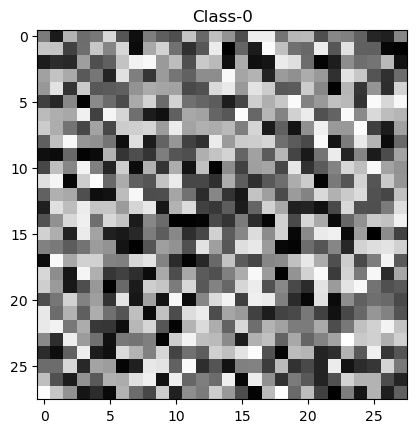

iteration number:  500


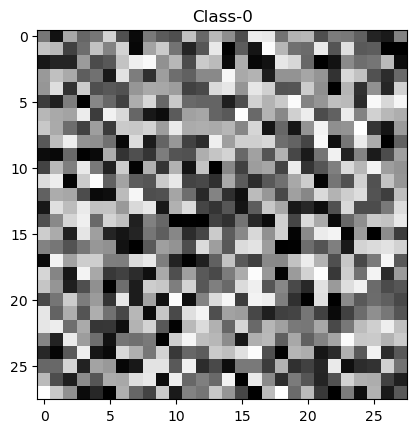

iteration number:  1000


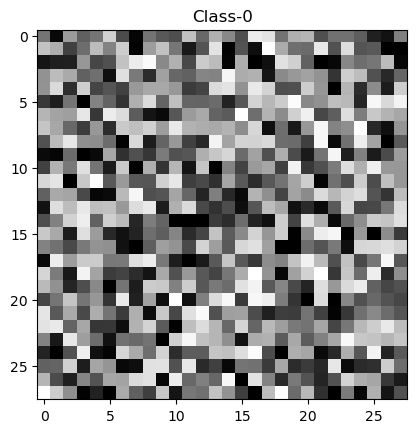

iteration number:  1500


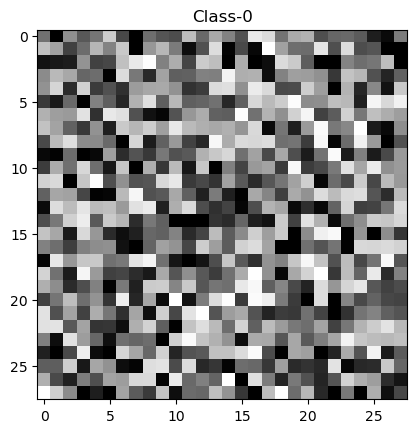

iteration number:  2000


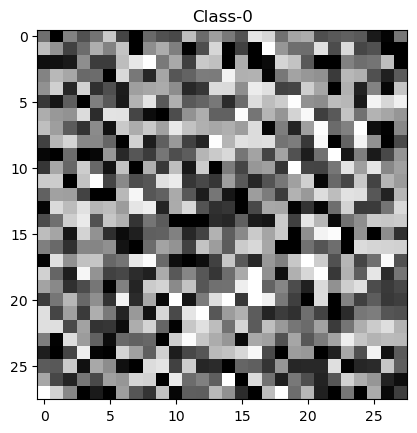

iteration number:  2500


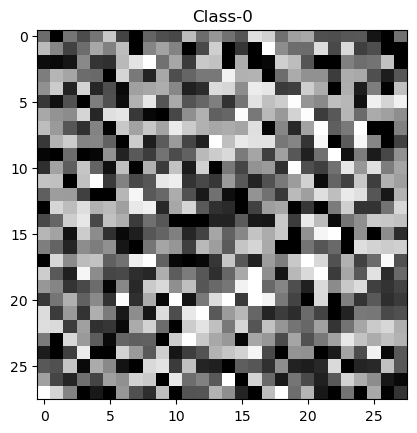

iteration number:  3000


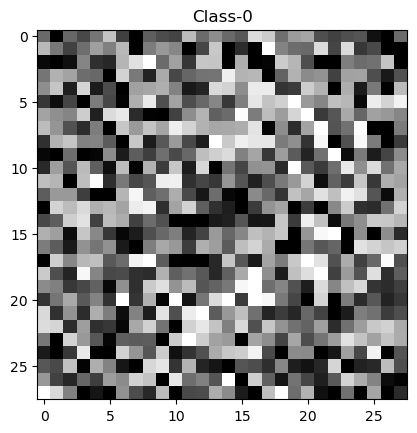

wtf


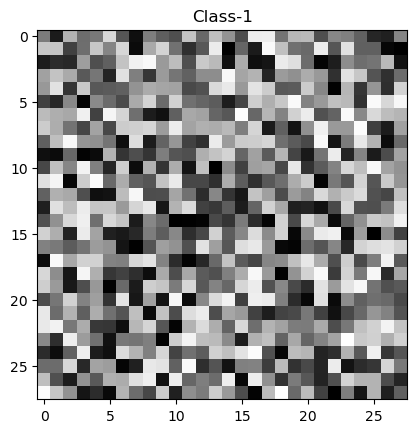

iteration number:  0


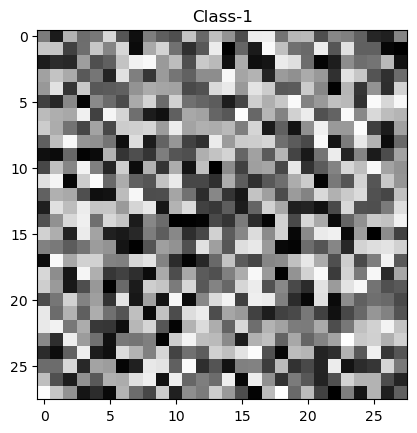

iteration number:  500


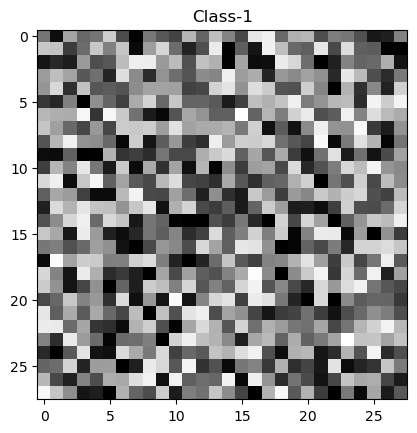

iteration number:  1000


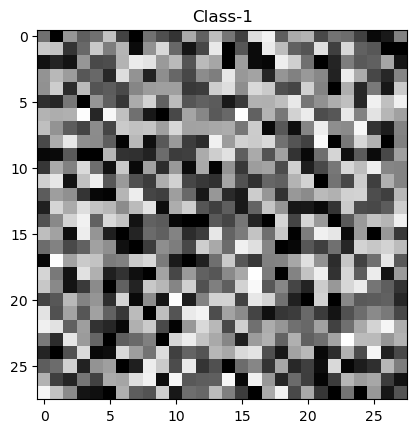

iteration number:  1500


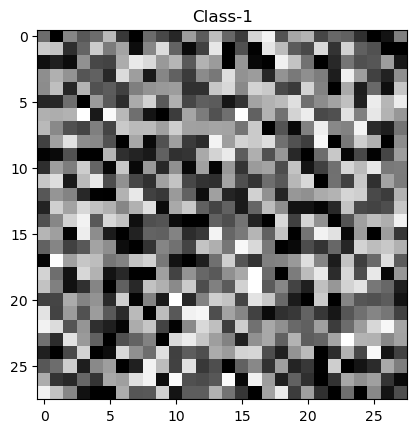

iteration number:  2000


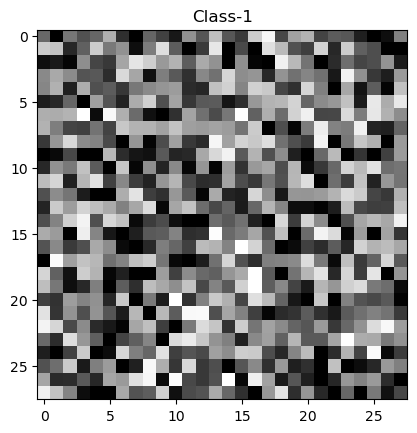

iteration number:  2500


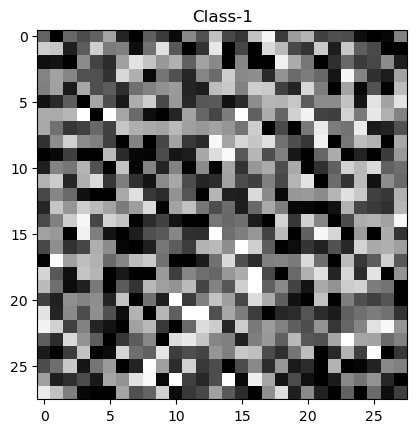

iteration number:  3000


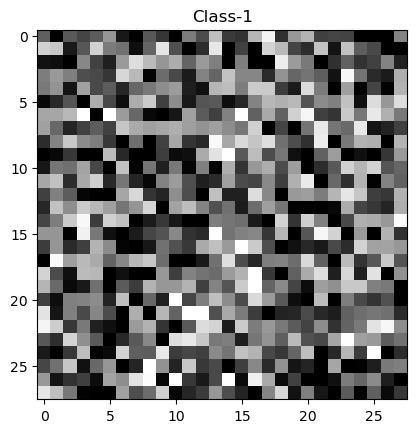

wtf


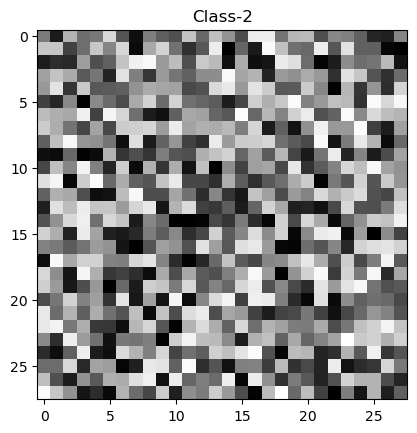

iteration number:  0


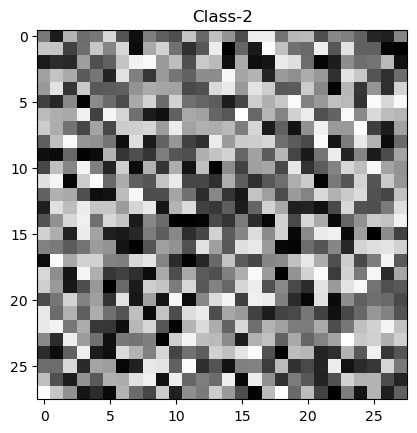

iteration number:  500


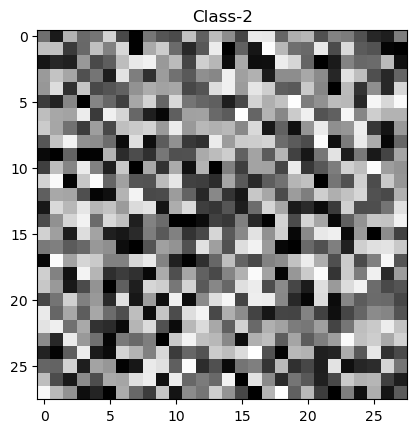

iteration number:  1000


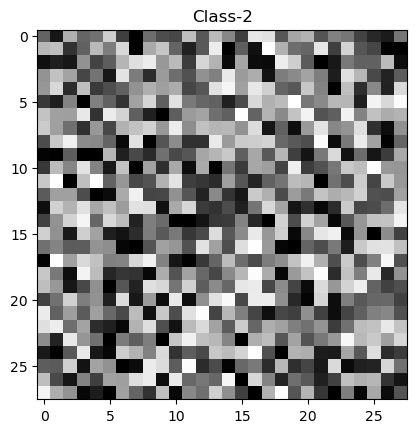

iteration number:  1500


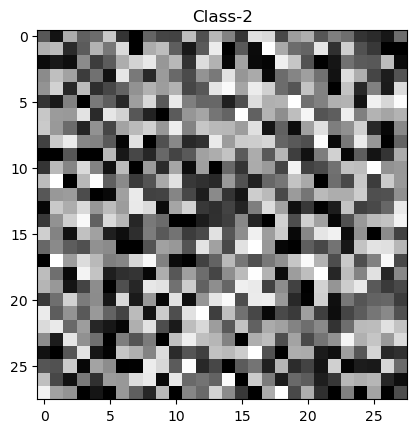

iteration number:  2000


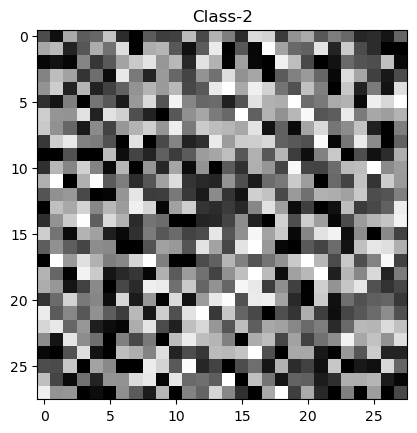

iteration number:  2500


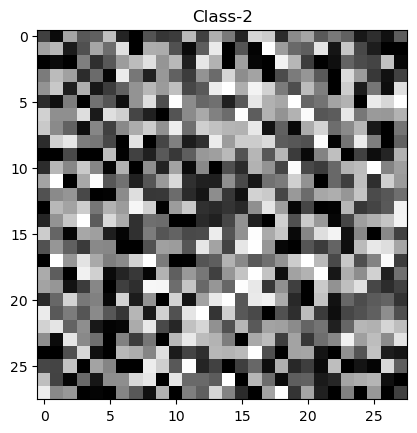

iteration number:  3000


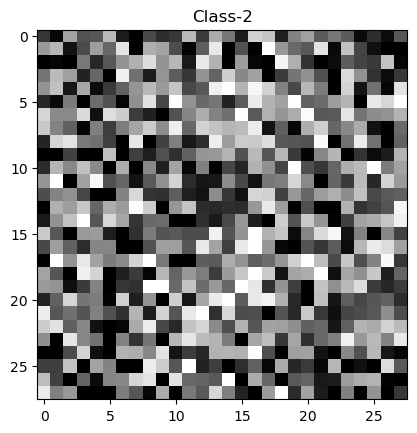

wtf


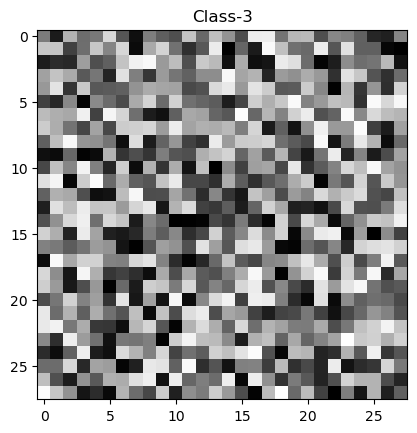

iteration number:  0


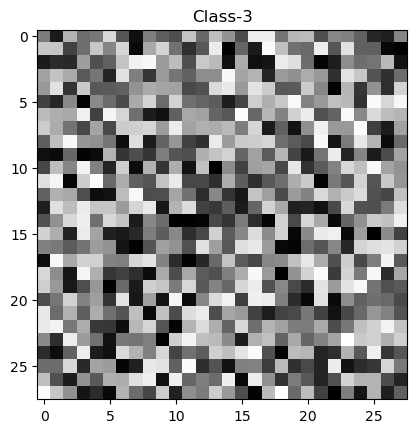

iteration number:  500


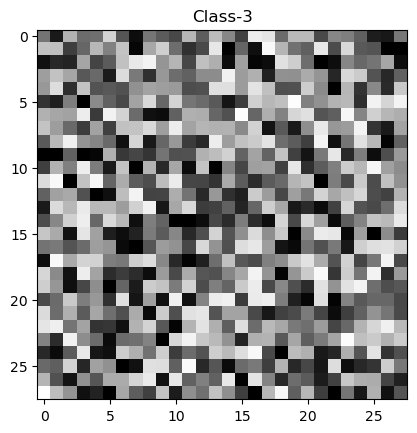

iteration number:  1000


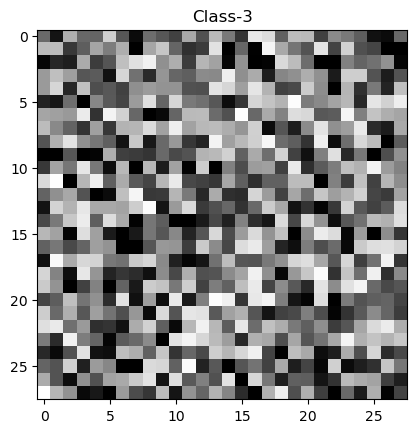

iteration number:  1500


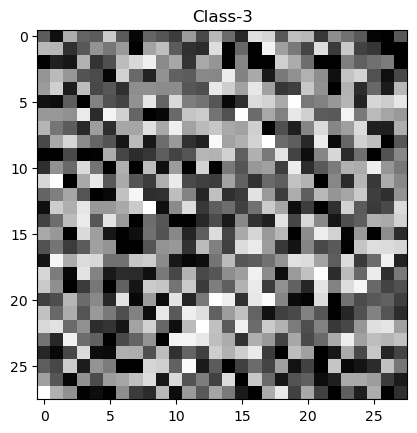

iteration number:  2000


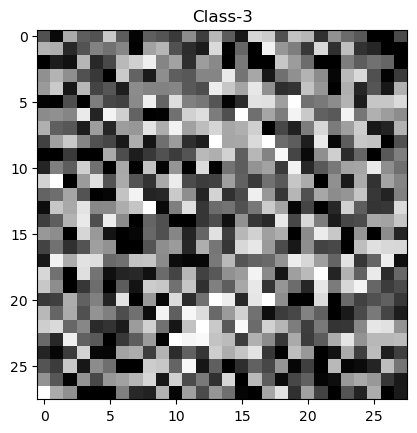

iteration number:  2500


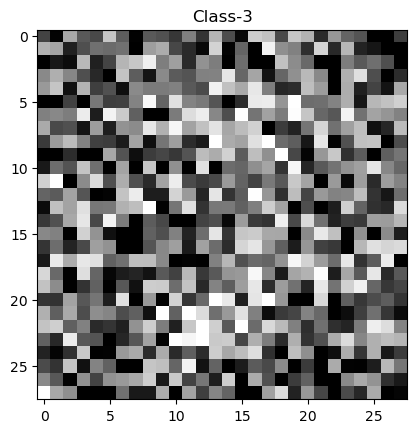

iteration number:  3000


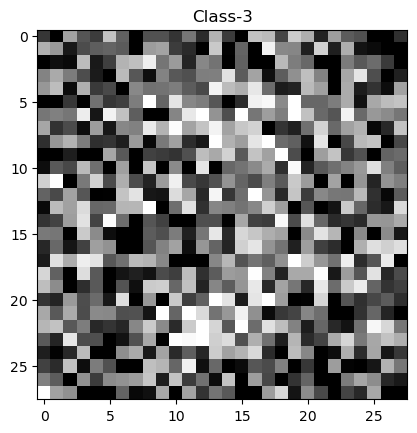

wtf


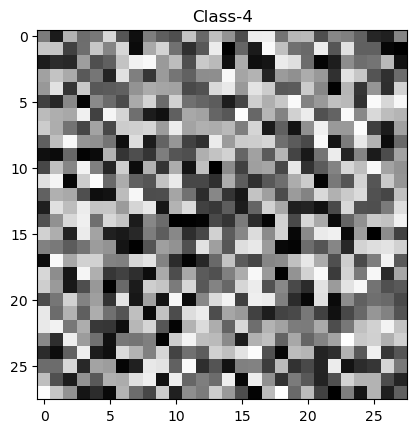

iteration number:  0


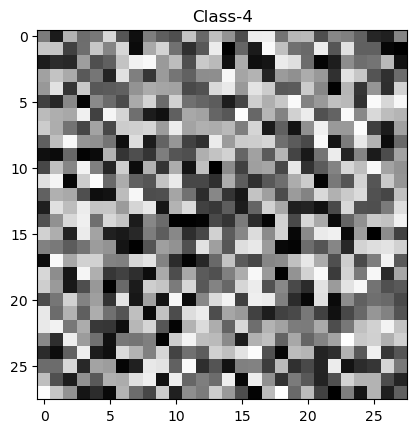

iteration number:  500


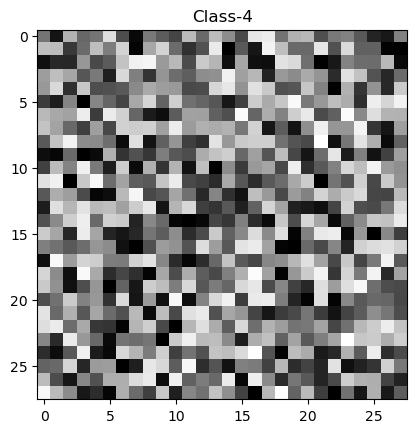

iteration number:  1000


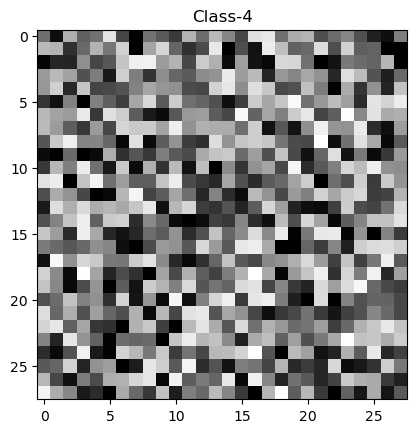

iteration number:  1500


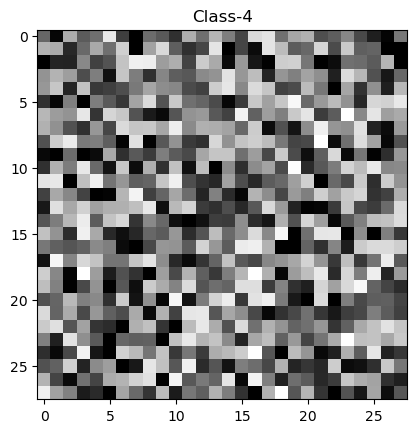

iteration number:  2000


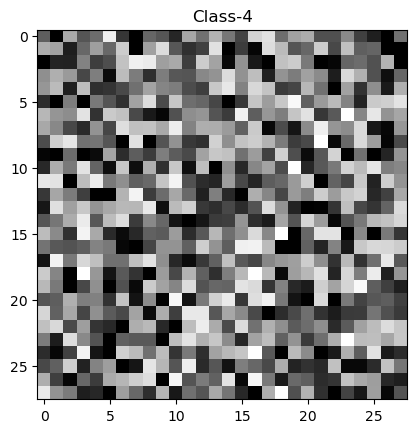

iteration number:  2500


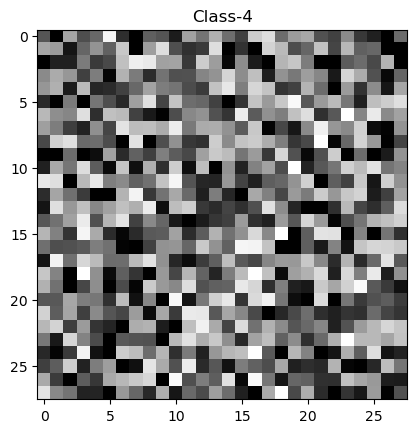

iteration number:  3000


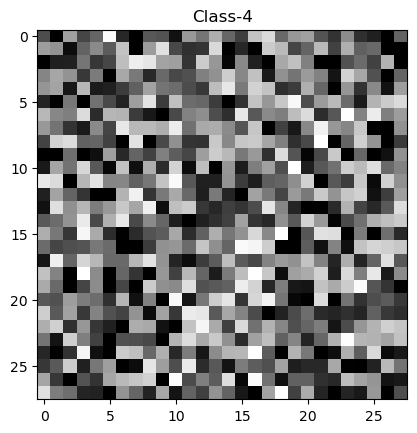

wtf


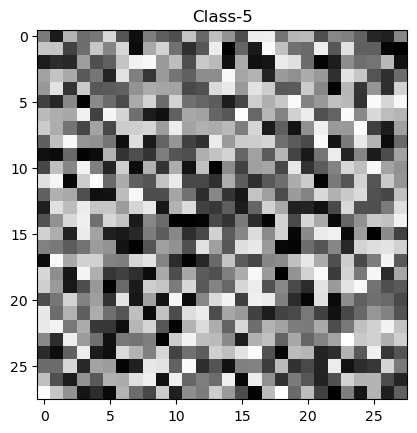

iteration number:  0


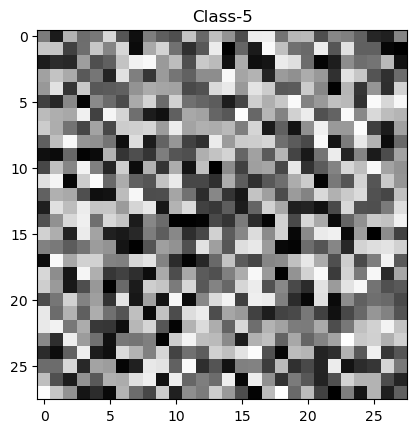

iteration number:  500


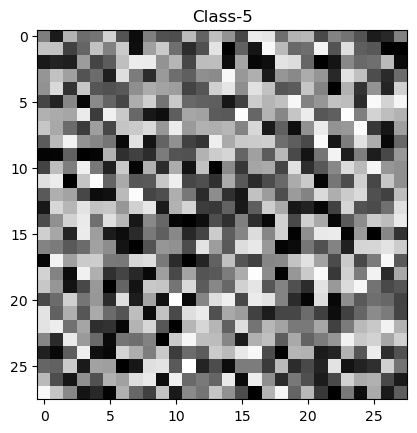

iteration number:  1000


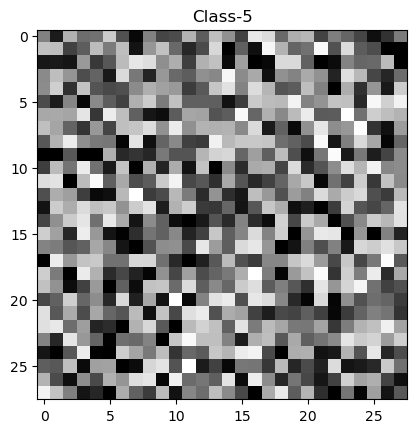

iteration number:  1500


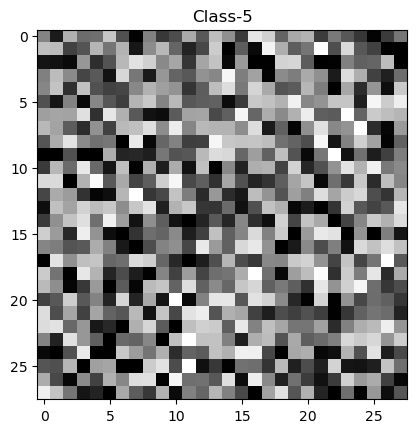

KeyboardInterrupt: 

In [ ]:
images_to_print = []
for cls in range(10):
    generated_image = generate(starting_noise=zero_vector_data.data[0].unsqueeze(0), 
            class_name=cls, 
            step_size=0.01, 
            iterations=3001,
            print_freq=500)
    images_to_print.append(generated_image.squeeze().detach().cpu().numpy())

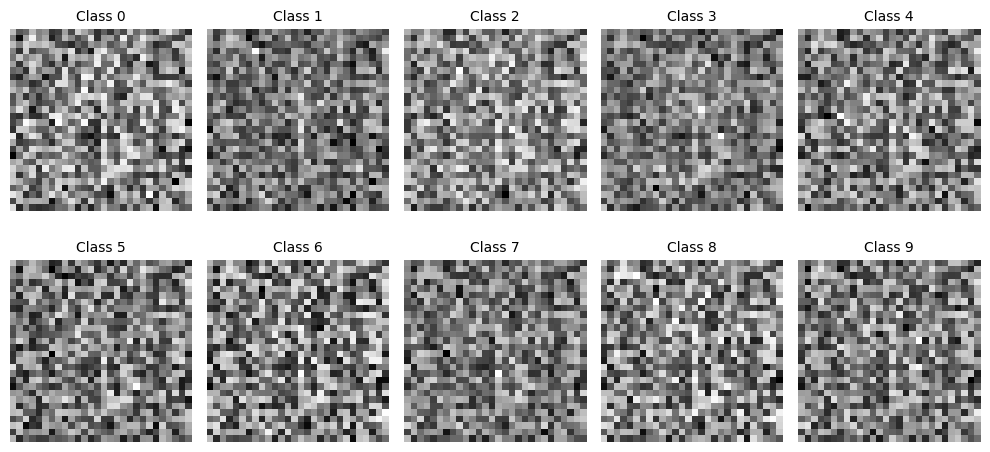

In [15]:
import matplotlib.pyplot as plt

# Assuming images_to_print contains 10 grayscale MNIST images
# Each image is a PyTorch tensor of shape (1, 28, 28) or (28, 28)
# images_to_print = [image.squeeze().cpu().numpy() for image in images_to_print]  # Convert to NumPy

# Create a figure with a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Adjust figsize as needed

# Plot each image in the grid
for idx, ax in enumerate(axes.ravel()):  # Flatten the 2D grid to iterate over axes
    ax.imshow(images_to_print[idx], cmap="gray")  # Display grayscale image
    ax.axis("off")  # Turn off axes for clarity
    ax.set_title(f"Class {idx}", fontsize=10)  # Optional: Add a title for each image

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the figure as a PDF
plt.savefig("mnist_grid.pdf", bbox_inches="tight")
plt.show()
